## Hand-made MLP

Dans le cadre du devoir 3 du cours IFT 6390, nous avons programmé à la main un MLP avec une couche cachée (nombre de neurones variables) à l'aide de numpy. Deux implémentations ont été crées pour comparer l'efficacité du calcul matriciel de numpy. La première utilisait des boucles pour effectuer les opérations matricielles alors que l'autre s'appuyait sur les outils de calcul matriciel de numpy.

L'architecture du MLP est la suivante :

entrée (x) -> 1ère couche linéaire (Wx + b) -> Non-linéarité (Relu) -> 2e couche linéaire (Wx + b) -> sortie (softmax)

Les deux couches étaient fully-connected et le nombres de neurones de la couche cachée était modifiable.

L'implémentation du MLP a ensuite été testé sur deux ensembles de données : l'un contenant des cercles de différentes grandeurs séparés en deux catégories, et l'autre étant Fashion MNIST contenant 10 classes. Différentes variations de paramètres pour les réseaux ont ensuite été étudiés.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

#importations des données
data = np.loadtxt(open('circles.txt','r'))

In [2]:
#Fonctions générales

def softmax(vecteur):    #Fonction softmax efficace, s'effectue sur un array de dimensions quelconques
    
    b = vecteur.max(axis=0)                     #ensure numerical stability
    divider = 1/np.sum(np.exp(vecteur-b),axis=0)      # normalization factor
    return np.exp(vecteur-b)*divider           #return the softmax vector

# Classe Neural_Network, boucles sur K exemple

In [238]:
class NN_boucles():

    def __init__(self,d,dh,m,lamb=[0,0,0,0]):
        '''d: dimension des données d'entrées
           dh: nombre de neurones de la couche cachée
           m: dimension de la sortie; nombre de classe pour la classification
           lam : paramètres pour le 'weight decay'
           
           Initialisera un réseau de neurones avec une couche caché et dont les poids initiaux sont aléatoires'''
        
        self.d = d
        self.dh = dh
        self.m = m
        self.lamb = lamb
        
        self.W2 = (2/math.sqrt(dh))*np.random.random_sample((m,dh)) - (1/math.sqrt(dh))        #vecteur m X dh
        self.b2 = np.zeros((m,1))    #vecteur m X 1 
        
        self.W1 = (2/math.sqrt(d))*np.random.random_sample((dh,d)) - (1/math.sqrt(d))        # vecteur dh X d
        self.b1 = np.zeros((dh,1)) #vecteur dh X 1
        
    def fprop(self,x):
        ''' Effectue la forward propagation et retourne dans un tuple les sorties de chaque couche 
            x: un vecteur d'entrée
            
            return:
            ha: sortie première couche, pré non-linéarité
            hs: sortie première couche, après non-linéarité
            oa sortie deuxième couche, pré non-linéarité
            os sortie finale, après non-linéarité'''
        xx=x
        if len(x.shape) == 1:
            xx.shape = (x.shape[0],1)
        
        ha = np.dot(self.W1,xx) + self.b1  #h_a = W1*x + b1
        
        hs = (ha>0) * ha  #h_s = rect(h_a)
        
        oa = np.dot(self.W2,hs) + self.b2   # o_a = W2*h_s + b2
        
        os = softmax(oa)   # o_s = softmax(o_a)
        
        return ha,hs,oa,os
        
    def bprop(self,ha,hs,oa,os,x,t):
        ''' Prend en entrée les dernières sortie de chaque couche et retourne les gradients de variation des
            paramètres, sans les mettre à jour. Prends aussi en entrés les target des datas t
            
            return:
            grad_W1 : gradient des poids W1
            grad_b1: gradient du biais b1
            grad_W2 : gradient des poids W2
            grad_b2:gradient du biais b2
        '''
        xx=x
        if len(x.shape) == 1:
            xx.shape = (x.shape[0],1)
        
        manip = np.eye(os.shape[0])[:,int(t)]
        if len(manip.shape) ==1 :
            manip.shape = (os.shape[0],1)
        grad_oa = os-manip
        
        L1_W2 = (self.W2>0)*np.ones(self.W2.shape) + ((self.W2<0)*np.ones(self.W2.shape)*-1)
        L2_W2 = 2*self.W2
        grad_W2 = np.dot(grad_oa,np.transpose(hs)) + self.lamb[2]*L1_W2 + self.lamb[3]*L2_W2
        grad_b2 = grad_oa                       
        
        grad_hs = np.dot(np.transpose(self.W2),grad_oa)
        grad_ha = (ha>0)*grad_hs
        
        L1_W1 = (self.W1>0)*np.ones(self.W1.shape) + ((self.W1<0)*np.ones(self.W1.shape)*-1)
        L2_W1 = 2*self.W1
        grad_W1 = np.dot(grad_ha,np.transpose(xx))+ self.lamb[0]*L1_W1 + self.lamb[1]*L2_W1
        grad_b1 = grad_ha
        
        return (grad_W1,grad_b1,grad_W2,grad_b2)   # Seules quantités qui nous serviront à mettre à jour nos paramètres
    
    def K_bprop(self,data,K):
        """ Fonction calculant un gradient par mini-lot de K exemples, en faisant une boucle dessus
            Utilise la fonction bprop
            K: taille des mini-lots, extraits de data
            
            return:
            grad_W1 : gradient des poids W1
            grad_b1: gradient du biais b1
            grad_W2 : gradient des poids W2
            grad_b2:gradient du biais b2
            
        """
        grad_W1,grad_b1,grad_W2,grad_b2 = 0,0,0,0
        
        for i in range(K):
            x = data[i][:-1]
            x.shape = (x.shape[0],1)
            t = data[i][-1]
            
            exemple = self.fprop(x)
            ha,hs,oa,os = exemple[0],exemple[1],exemple[2],exemple[3]
            parameters= self.bprop(ha,hs,oa,os,x,t)
            grad_W1 += parameters[0]
            grad_b1 += parameters[1]
            grad_W2 += parameters[2]
            grad_b2 += parameters[3]
            
        return (grad_W1/K,grad_b1/K,grad_W2/K,grad_b2/K)
    
    
    def update(self,eta,grad_W1,grad_b1,grad_W2,grad_b2):
        '''Prend les quantités calculées pendant la back propagation et met à jour nos paramètres par descente de gradient
           
           eta: pas de la descente de gradient, fixé par l'utilisateur
        '''
        
        self.W1 = self.W1 - eta*grad_W1
        self.W2 = self.W2 - eta*grad_W2
        self.b1 = self.b1 - eta*grad_b1
        self.b2 = self.b2 - eta*grad_b2
        
    def predict(self,x):           #effectue une prédiction vers la classe 0 ou 1
        
        os = self.fprop(x)[3]
        return np.argmax(os)

# Problème 3.1 et 3.2

In [81]:
#Vérification pour un exemple du gradient par différence finie pour un exemple
#On prend la première donnée de l'ensemble des cercles pour faire le test ici

Simple_Network = NN_boucles(2,2,2)   # m à préciser selon les données

exemple = data[0][:-1]
exemple.shape = (2,1)
target = data[0][-1]

parameters= Simple_Network.fprop(exemple)
os_for_loss = parameters[3]
gradients = Simple_Network.bprop(parameters[0],parameters[1],parameters[2],parameters[3],exemple,target)

Simple_Network.W1 += 0.00001
Simple_Network.W2 += 0.00001
Simple_Network.b1 += 0.00001
Simple_Network.b2 += 0.00001

os2_for_loss = Simple_Network.fprop(exemple)[3]

Loss = (np.log(os_for_loss[int(target)]) - np.log(os2_for_loss[int(target)]))/0.00001

print((gradients[0].sum()+gradients[1].sum()+gradients[2].sum()+gradients[3].sum())/Loss)


[1.00000175]


Ce qui confirme que notre implémentation du gradient pour un exemple de notre réseau de neurones est valide

# Problème 3.3 et 3.4

In [82]:
#Vérification pour un exemple du gradient par différence finie pour K exemples, via boucle
#On prend les dix premières données de l'ensemble des cercles pour faire le test ici

Simple_Network = NN_boucles(2,2,2)   # m à préciser selon les données

os_for_loss=  []
for i in data[:10]:
    exemple = i[:-1]
    exemple.shape = (2,1)
    parameters = Simple_Network.fprop(exemple)
    os_for_loss.append(parameters[3])
    
gradients = Simple_Network.K_bprop(data[:10],10)

Simple_Network.W1 += 0.00001
Simple_Network.W2 += 0.00001
Simple_Network.b1 += 0.00001
Simple_Network.b2 += 0.00001

os2_for_loss = []
for i in data[:10]:
    exemple = i[:-1]
    exemple.shape = (2,1)
    parameters = Simple_Network.fprop(exemple)
    os2_for_loss.append(parameters[3])

Loss = 0
target = data[:10,-1]
for i in range(len(os2_for_loss)):
    Loss += (np.log(os_for_loss[i][int(target[i])]) - np.log(os2_for_loss[i][int(target[i])]))/0.00001
    
Loss = Loss/10

print((gradients[0].sum()+gradients[1].sum()+gradients[2].sum()+gradients[3].sum())/Loss)

[1.00000011]


Ce qui confirme que notre implémentation des gradients pour un entraînement sur K-exemples via une boucle est valide

# Problème 3.5

## Nous étudions d'abord la variation de la capacité en fonction du nombres de neurones

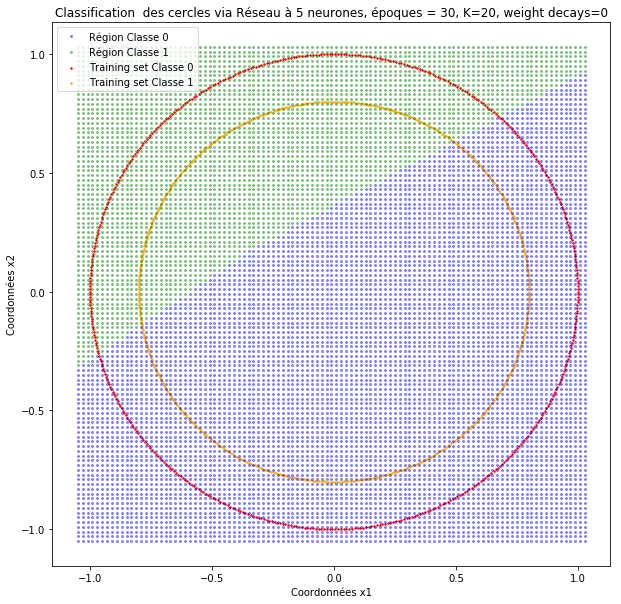

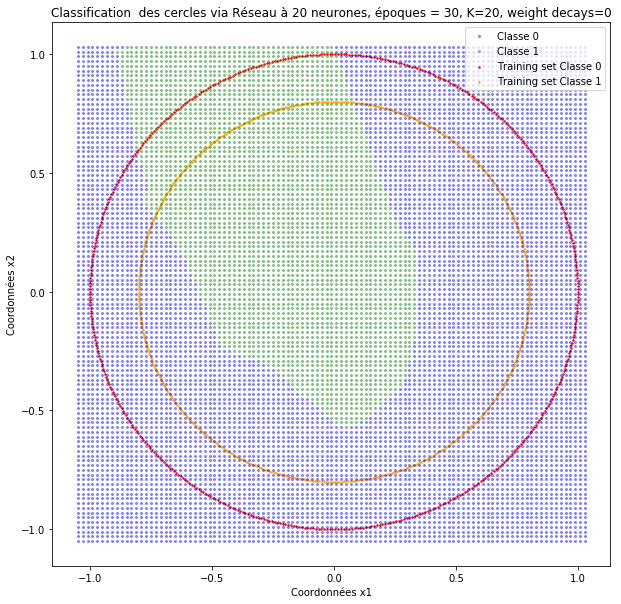

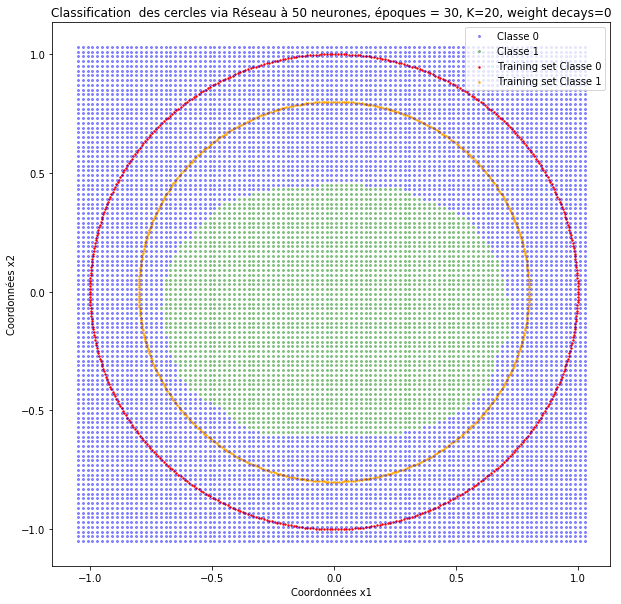

In [158]:
# Nous allons tout d'abord varié le nombre de neurones dans la couche cachée

NN_5N = NN_boucles(2,5,2) #Réseau avec 5 neurones cachées
NN_20N = NN_boucles(2,20,2) #Réseau avec 20 neurones cachées
NN_50N = NN_boucles(2,50,2) #Réseau avec 50 neurones cachées

# Nous allons procéder avec 30 époques d'entraînement, sans weight-decay, K=20

for j in range(30):               #Époques d'entraînement
    
    for i in range(0,len(data),20):    #K=20
        grads_5N = NN_5N.K_bprop(data[i:i+20],20)
        grads_20N = NN_20N.K_bprop(data[i:i+20],20)
        grads_50N = NN_50N.K_bprop(data[i:i+20],20)         # On calcule le grandient pour une K-batch
        
        eta = 0.01 / (1 + (4*j/10))
        NN_5N.update(eta,*grads_5N)
        NN_20N.update(eta,*grads_20N)
        NN_50N.update(eta,*grads_50N)
        
# Partie graphique:

min1 = data[:,0].min() -0.05
max1 = data[:,0].max() +0.05
min2 = data[:,1].min() -0.05
max2 = data[:,1].max() +0.05
detail = 0.02

x1_mesh = np.arange(min1, max2, detail)
x2_mesh = np.arange(min1, max2, detail)
mesh_grid = np.meshgrid(x1_mesh, x2_mesh)

## Pour Réseau à 5 neurones:

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_5N.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_5N.predict(grid[:,i]) == 1])

plt.figure(1, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles via Réseau à 5 neurones, époques = 30, K=20, weight decays=0")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

## Pour Réseau à 20 neurones:

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_20N.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_20N.predict(grid[:,i]) == 1])

plt.figure(2, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles via Réseau à 20 neurones, époques = 30, K=20, weight decays=0")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

## Pour Réseau à 50 neurones:

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_50N.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_50N.predict(grid[:,i]) == 1])

plt.figure(3, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles via Réseau à 50 neurones, époques = 30, K=20, weight decays=0")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)
    

## Maintenant, nous allons maintenant observer l'amélioration en fonction du nombre d'époques

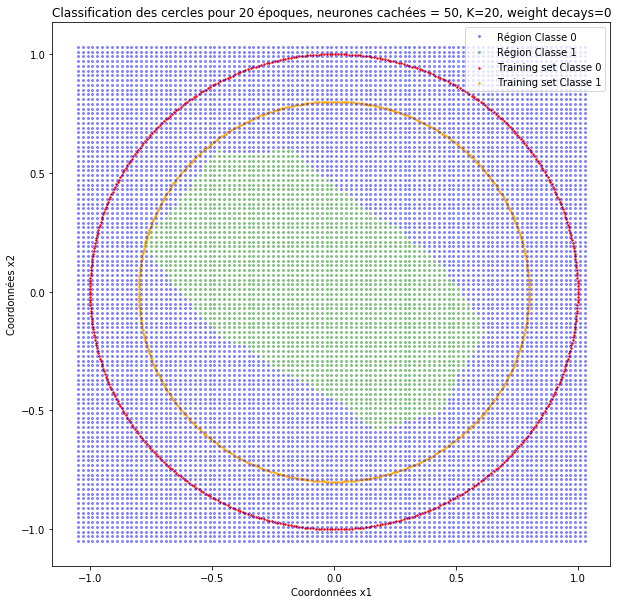

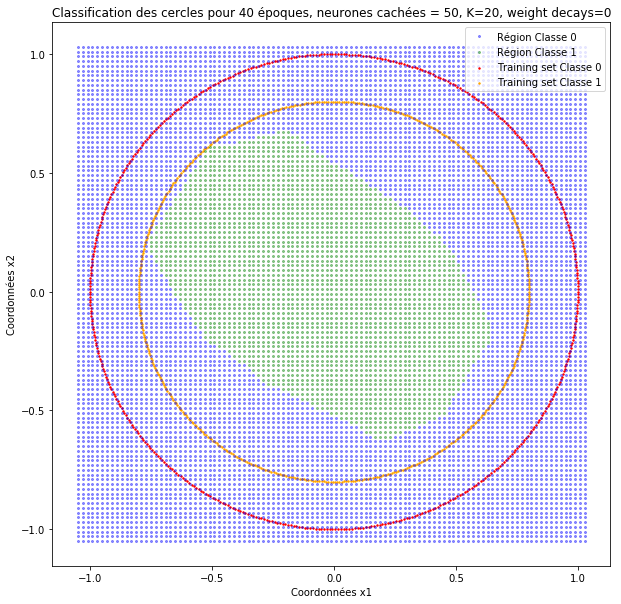

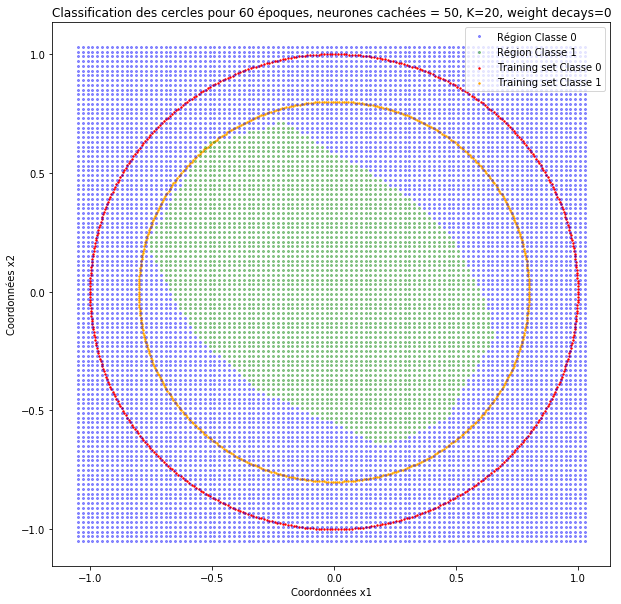

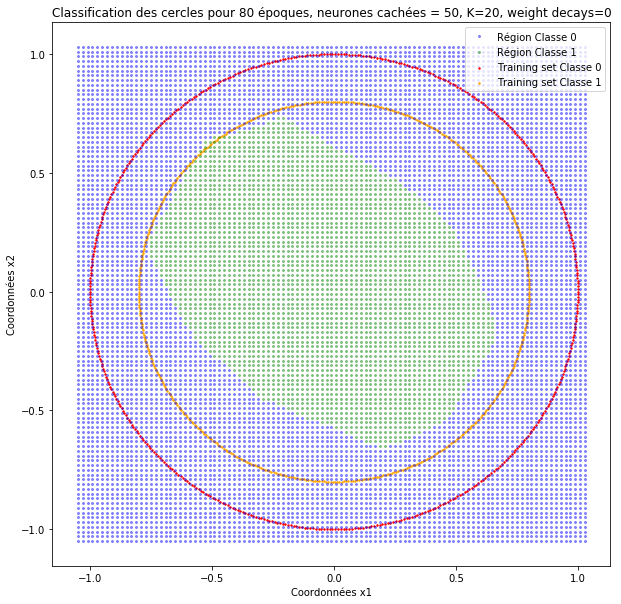

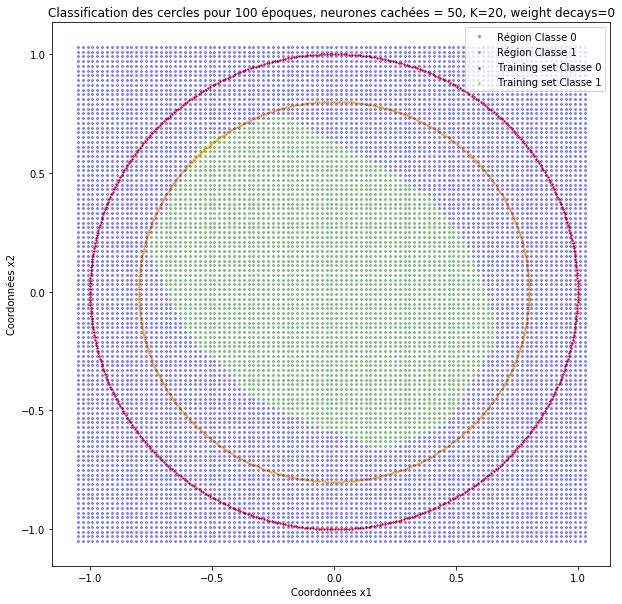

In [161]:
# Nous produirons les graphiques au fur et à mesure de l'entraînement

NN_epoc = NN_boucles(2,50,2) #Réseau avec 50 neurones cachées

#Préambule pour la portion graphique

min1 = data[:,0].min() -0.05
max1 = data[:,0].max() +0.05
min2 = data[:,1].min() -0.05
max2 = data[:,1].max() +0.05
detail = 0.02

x1_mesh = np.arange(min1, max2, detail)
x2_mesh = np.arange(min1, max2, detail)
mesh_grid = np.meshgrid(x1_mesh, x2_mesh)

# Nous allons procéder avec 50 neurones, sans weight-decay, K=20

for j in range(100):               #Époques d'entraînement
    
    for i in range(0,len(data),20):    #K=20
        grads_epoc = NN_epoc.K_bprop(data[i:i+20],20)      # On calcule le grandient pour une K-batch
        
        eta = 0.01 / (1 + (4*j/10))
        NN_epoc.update(eta,*grads_epoc)
        
    if (j+1)%20 == 0:                      #On produit les graphiques par bond de 20 époques
        
        pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_epoc.predict(grid[:,i]) == 0])
        pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_epoc.predict(grid[:,i]) == 1])

        plt.figure((j+1)/20, figsize=(10,10))
        plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
        plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
        plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
        plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

        plt.title("Classification des cercles pour " + str(j+1) +" époques, neurones cachées = 50, K=20, weight decays=0")
        plt.xlabel("Coordonnées x1")
        plt.ylabel("Coordonnées x2")
        plt.legend(loc=0)

## Et finalement, nous introduisons des 'weight decays' et observons leurs effets

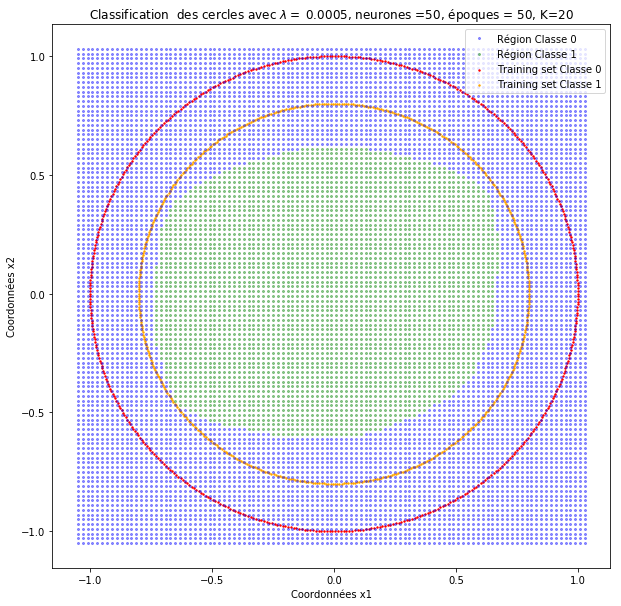

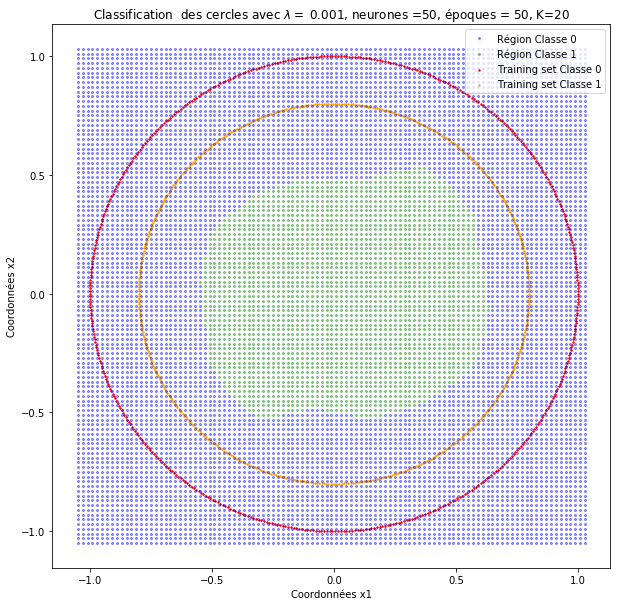

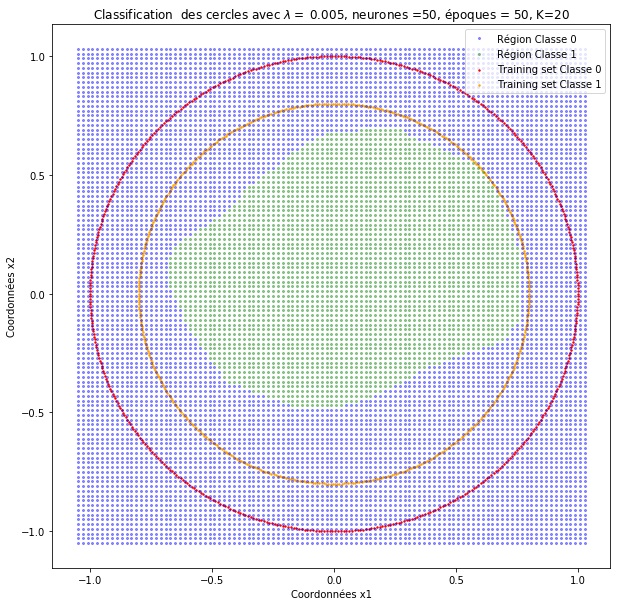

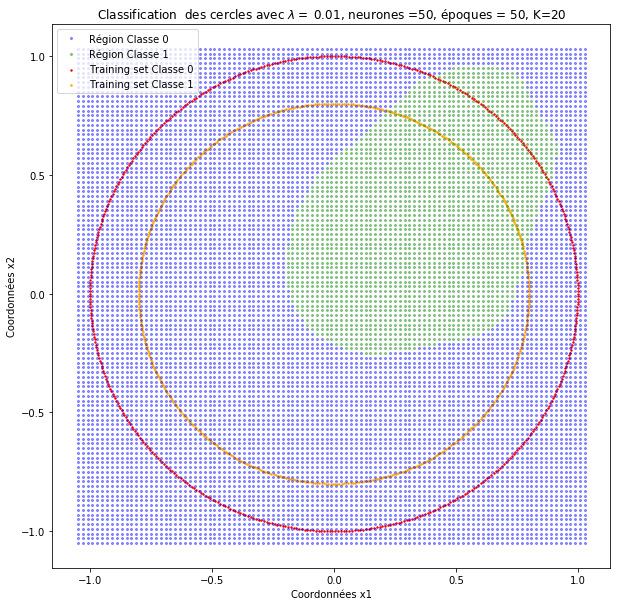

In [162]:
# Nous testons plusieurs weight decays, avec 50 neurones cachées et 50 époques d'entraînement

NN_1 = NN_boucles(2,50,2,lamb=[0.0005,0.0005,0.0005,0.0005])    #Petit Weight decay
NN_2 = NN_boucles(2,50,2,lamb=[0.001,0.001,0.001,0.001])
NN_3 = NN_boucles(2,50,2,lamb=[0.005,0.005,0.005,0.005])
NN_4 = NN_boucles(2,50,2,lamb=[0.01,0.01,0.01,0.01])            # Grand weight decay

# Nous allons procéder avec 50 époques d'entraînement, 50 neurones K=20

for j in range(50):               #Époques d'entraînement
    
    for i in range(0,len(data),20):    #K=20
        grads_1 = NN_1.K_bprop(data[i:i+20],20)
        grads_2 = NN_2.K_bprop(data[i:i+20],20)
        grads_3 = NN_3.K_bprop(data[i:i+20],20)
        grads_4 = NN_4.K_bprop(data[i:i+20],20)         # On calcule le grandient pour une K-batch
        
        eta = 0.01 / (1 + (4*j/10))
        NN_1.update(eta,*grads_1)
        NN_2.update(eta,*grads_2)
        NN_3.update(eta,*grads_3)
        NN_4.update(eta,*grads_3)
        
# Partie graphique:

min1 = data[:,0].min() -0.05
max1 = data[:,0].max() +0.05
min2 = data[:,1].min() -0.05
max2 = data[:,1].max() +0.05
detail = 0.02

x1_mesh = np.arange(min1, max2, detail)
x2_mesh = np.arange(min1, max2, detail)
mesh_grid = np.meshgrid(x1_mesh, x2_mesh)

## Pour lamb=0.0005

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_1.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_1.predict(grid[:,i]) == 1])

plt.figure(11, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles avec $\lambda =$ 0.0005, neurones =50, époques = 50, K=20")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

## Pour lamb=0.001

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_2.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_2.predict(grid[:,i]) == 1])

plt.figure(12, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles avec $\lambda =$ 0.001, neurones =50, époques = 50, K=20")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

## Pour lamb=0.005

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_3.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_3.predict(grid[:,i]) == 1])

plt.figure(13, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles avec $\lambda =$ 0.005, neurones =50, époques = 50, K=20")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

## Pour lamb=0.01

pred_0 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_4.predict(grid[:,i]) == 0])
pred_1 = np.array([grid[:,i] for i in range(grid.shape[1]) if NN_4.predict(grid[:,i]) == 1])

plt.figure(14, figsize=(10,10))
plt.plot(pred_0[:,0], pred_0[:,1],"o", markersize = 2, color = 'b', alpha = 0.4, label='Région Classe 0')
plt.plot(pred_1[:,0], pred_1[:,1],"o", markersize = 2, color = 'g', alpha = 0.4, label='Région Classe 1')
        
plt.scatter(data[np.where(data[:,2] == 0)][:,0],data[np.where(data[:,2] == 0)][:,1],color='r', s=2, label='Training set Classe 0')
plt.scatter(data[np.where(data[:,2] == 1)][:,0],data[np.where(data[:,2] == 1)][:,1],color='orange', s=2, label='Training set Classe 1')

plt.title("Classification  des cercles avec $\lambda =$ 0.01, neurones =50, époques = 50, K=20")
plt.xlabel("Coordonnées x1")
plt.ylabel("Coordonnées x2")
plt.legend(loc=0)

# Problème 3.6

In [487]:
class NN_matrix():           # Toutes les opérations se feront par calcul matriciel

    def __init__(self,d,dh,m,lamb=[0,0,0,0]):
        '''d: dimension des données d'entrées
           dh: nombre de neurones de la couche cachée
           m: dimension de la sortie; nombre de classe pour la classification
           lam : paramètres pour le 'weight decay'
           
           Initialisera un réseau de neurones avec une couche caché et dont les poids initiaux sont aléatoires'''
        
        self.d = d
        self.dh = dh
        self.m = m
        self.lamb = lamb
        
        self.W2 = (2/math.sqrt(dh))*np.random.random_sample((m,dh)) - (1/math.sqrt(dh))        #vecteur m X dh
        self.b2 = np.zeros((m,1))    #vecteur m X 1 
        
        self.W1 = (2/math.sqrt(d))*np.random.random_sample((dh,d)) - (1/math.sqrt(d))        # vecteur dh X d
        self.b1 = np.zeros((dh,1)) #vecteur dh X 1
        
    def fprop(self,x):
        ''' Effectue la forward propagation et retourne dans un tuple les sorties de chaque couche 
            x: un vecteur d'entrée
            
            return:
            ha: sortie première couche, pré non-linéarité
            hs: sortie première couche, après non-linéarité
            oa sortie deuxième couche, pré non-linéarité
            os sortie finale, après non-linéarité'''
        xx=x
        if len(x.shape) == 1:
            xx.shape = (x.shape[0],1)
    
        new_b1= np.repeat(self.b1,x.shape[1],axis=1)
        new_b2= np.repeat(self.b2,x.shape[1],axis=1)
            
        
        ha = np.dot(self.W1,xx) + new_b1  #h_a = W1*x + b1
        
        hs = (ha>0) * ha  #h_s = rect(h_a)
        
        oa = np.dot(self.W2,hs) + new_b2   # o_a = W2*h_s + b2
        
        os = softmax(oa)   # o_s = softmax(o_a)
        
        return ha,hs,oa,os

    def Dummyfprop(self,x,W1,b1,W2,b2):
        ''' Effectue la forward propagation et retourne dans un tuple les sorties de chaque couche 
            x: un vecteur d'entrée
            
            return:
            ha: sortie première couche, pré non-linéarité
            hs: sortie première couche, après non-linéarité
            oa sortie deuxième couche, pré non-linéarité
            os sortie finale, après non-linéarité'''
        xx=x
        if len(x.shape) == 1:
            xx.shape = (x.shape[0],1)
    
        new_b1= np.repeat(b1,x.shape[1],axis=1)
        new_b2= np.repeat(b2,x.shape[1],axis=1)
            
        
        ha = np.dot(W1,xx) + new_b1  #h_a = W1*x + b1
        
        hs = (ha>0) * ha  #h_s = rect(h_a)
        
        oa = np.dot(W2,hs) + new_b2   # o_a = W2*h_s + b2
        
        os = softmax(oa)   # o_s = softmax(o_a)
        
        return ha,hs,oa,os

    
    def bprop(self,ha,hs,oa,os,x,t):
        ''' Prend en entrée les dernières sortie de chaque couche et retourne les gradients de variation des
            paramètres, sans les mettre à jour. Prends aussi en entrés les target des datas t
            
            return:
            grad_W1 : gradient des poids W1
            grad_b1: gradient du biais b1
            grad_W2 : gradient des poids W2
            grad_b2:gradient du biais b2
        '''
        
        xx=x
        if len(x.shape) == 1:
            xx.shape = (x.shape[0],1)
        
        K = xx.shape[1]
        onehot_K = np.zeros((self.m,K))
        for i in range(K):
            try:
                onehot_K[int(t[i]),i] = 1
            except IndexError:
                onehot_K[int(t),i] = 1
        
        grad_oa = os-onehot_K
        
        L1_W2 = (self.W2>0)*np.ones(self.W2.shape) + ((self.W2<0)*np.ones(self.W2.shape)*-1)
        L2_W2 = 2*self.W2
        grad_W2 = np.dot(grad_oa,np.transpose(hs)) + self.lamb[2]*L1_W2 + self.lamb[3]*L2_W2
        grad_b2 = grad_oa                       
        
        grad_hs = np.dot(np.transpose(self.W2),grad_oa)
        grad_ha = (ha>0)*grad_hs
        
        L1_W1 = (self.W1>0)*np.ones(self.W1.shape) + ((self.W1<0)*np.ones(self.W1.shape)*-1)
        L2_W1 = 2*self.W1
        grad_W1 = np.dot(grad_ha,np.transpose(x))+ self.lamb[0]*L1_W1 + self.lamb[1]*L2_W1
        grad_b1 = grad_ha
        
        return (grad_W1/K,grad_b1.sum(axis=1,keepdims=True)/K,grad_W2/K,grad_b2.sum(axis=1,keepdims=True)/K)   # Seules quantités qui nous serviront à mettre à jour nos paramètres
    
    
    def update(self,eta,grad_W1,grad_b1,grad_W2,grad_b2):
        '''Prend les quantités calculées pendant la back propagation et met à jour nos paramètres par descente de gradient
           
           eta: pas de la descente de gradient, fixé par l'utilisateur
        '''
        
        self.W1 = self.W1 - eta*grad_W1
        self.W2 = self.W2 - eta*grad_W2
        self.b1 = self.b1 - eta*grad_b1
        self.b2 = self.b2 - eta*grad_b2
        
    def predict(self,x):           #effectue une prédiction vers la classe 0 ou 1
        
        os = self.fprop(x)[3]
        return np.argmax(os,axis=0)

# Problème 3.7

In [419]:
NN_test_M = NN_matrix(2,4,2)
NN_test_boucles = NN_boucles(2,4,2)

NN_test_boucles.W1 = NN_test_M.W1    # Il faut que les matrices de poids soient égales pour faire la comparaison
NN_test_boucles.W2 = NN_test_M.W2

# Pour K == 1
erreurs = 0
for i in range(len(data)):
    param1 = NN_test_M.fprop(data[i,:-1])
    param2 = NN_test_boucles.fprop(data[i,:-1])
    grad1 = NN_test_M.bprop(*param1,data[i,:-1],data[i,-1])
    grad2 = NN_test_boucles.bprop(*param1,data[i,:-1],data[i,-1])
    
    for j in range(len(grad1)):
        if (grad1[j]-grad2[j]).sum() > 0.001:
            erreurs += 1

print('Si tous les gradients sont égaux, la somme des erreurs devrait être nulle')
print('Le total des erreurs : '+ str(erreurs))

# Pour K == 10

erreurs=0
for i in range(0,len(data),10):
    param1 = NN_test_M.fprop(data[i:i+10,:-1].transpose())
    grad1 = NN_test_M.bprop(*param1,data[i:i+10,:-1].transpose(),data[i:i+10,-1])
    grad2 = NN_test_boucles.K_bprop(data[i:i+10],10)
    
    for j in range(len(grad1)):
        if (grad1[j]-grad2[j]).sum() > 0.001:
            erreurs += 1
print('Si tous les gradients sont égaux, la somme des erreurs devrait être nulle')
print('Le total des erreurs : '+ str(erreurs))

Si tous les gradients sont égaux, la somme des erreurs devrait être nulle
Le total des erreurs : 0
Si tous les gradients sont égaux, la somme des erreurs devrait être nulle
Le total des erreurs : 0


# Problème 3.8



In [420]:
# On importe d'abord l'ensemble de données fashion, que nous n'avons pas encore utilisé
import utils.mnist_reader as mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

#On import aussi le module time
import time

In [473]:
# Nous allons faire le teste pour différents nombre de neurones:

NN_1_epoc_boucles = NN_boucles(784,50,10)    #Réseau de neurones avec boucles
NN_1_epoc_M = NN_matrix(784,50,10)           #Réseau de neurones, implémentation matricielle

new_y = y_train
new_y.shape = (y_train.shape[0],1)
data_boucles = np.hstack((X_train,new_y))

eta = 0.01        #On utilisera le même pas de descente de gradient

t1 = time.time()
for i in range(0,len(X_train),100):    #K=100
    grad_boucles = NN_1_epoc_boucles.K_bprop(data_boucles[i:i+100],100)
        
    NN_1_epoc_boucles.update(eta,*grad_boucles)
    
t2 = time.time()

for i in range(0,len(X_train),100):
    param1 = NN_1_epoc_M.fprop(X_train[i:i+100].transpose())
    grad1 = NN_1_epoc_M.bprop(*param1,X_train[i:i+100].transpose(),new_y[i:i+100])
    NN_1_epoc_M.update(eta,*grad1)

t3 = time.time()

print("Pour un réseau de 50 neurones, l'implémentation avec boucles prend",str(t2-t1),"secondes")
print("Pour un réseau de 50 neurones, l'implémentation avec calcul matriciel prend",str(t3-t2),"secondes")
print()
print("Donc l'implémentation matricielle est environ",str((t2-t1)/(t3-t2)),"fois plus rapide")

Pour un réseau de 50 neurones, l'implémentation avec boucles prend 44.34560990333557 secondes
Pour un réseau de 50 neurones, l'implémentation avec calcul matriciel prend 1.4641625881195068 secondes

Donc l'implémentation matricielle est environ 30.287353510576125 fois plus rapide


# Problème 3.9 et 3.10

On apporte les modifications nécessaires et en profitons pour produire les graphiques en même temps

In [509]:
#Après avoir joué avec les hyper-paramètres, voici ceux qui on été retenus

NN_final_take = NN_matrix(784,70,10,lamb=[0.0002,0.0002,0.0002,0.0002])        #initiation du réseau de neurones

new_y = y_train
new_y.shape = (y_train.shape[0],1)      #on s'assure de la conformité des données

erreur_total =[]
loss_total=[]
err_train_moy=[]
loss_train_moy=[]
err_test_moy=[]
loss_test_moy=[]
loss_validate_moy=[]
err_validate_moy=[]

memory=1   #On veut garder en mémoire les paramètres qui donnent les meilleures performances
size_trainset = int(5/6 * len(X_train))

for j in range(30):    #Nous implémentons jusqu'à 30 époques d'entraînement
    
    eta = 0.0025/(1+(4*j/30))
    
    err=0
    loss=0
    K=50
    
    for i in range(0,size_trainset,K):            #On conserve une mini-batch de 100 exemplaires
        param1 = NN_final_take.fprop(X_train[i:i+K].transpose())
        grad1 = NN_final_take.bprop(*param1,X_train[i:i+K].transpose(),new_y[i:i+K])
        NN_final_take.update(eta,*grad1)
        classif = np.argmax(param1[3],axis=0)
        classif.shape=(K,1)
        err = err + np.sum((classif!=y_train[i:i+K]).astype(np.float32))   #Calcule de l'erreur pour fin de comparaison
     
        for k in range(K):
            loss += -1*np.log(param1[3][classif[k,0],k])

    erreur_total.append(err)
    loss_total.append(loss)
    err_train_moy.append(err/size_trainset)
    loss_train_moy.append(loss/size_trainset)
    
    os_validate = NN_final_take.fprop(X_train[size_trainset:].transpose())[3]
    test_cat_val=np.argmax(os_validate,axis=0)
    test_cat_val.shape=(test_cat_val.shape[0],1)
    err_validate_moy.append(np.sum((test_cat_val!=y_train[size_trainset:]).astype(np.float32))/len(y_train[size_trainset:]))
    loss_validate=0
    for k in range(len(test_cat_val)):
        loss_validate += -1*np.log(os_validate[test_cat_val[k,0],k])
    loss_validate_moy.append(loss_validate/(len(y_train)-size_trainset))
    
    if err_validate_moy[j]<memory:
        memory = err_validate_moy[j]
        mem_parameter = (NN_final_take.W1,NN_final_take.b1,NN_final_take.W2,NN_final_take.b2)
        
    os_test = NN_final_take.Dummyfprop(X_test.transpose(),*mem_parameter)[3]
    test_cat=np.argmax(os_test,axis=0)
    err_test_moy.append(np.sum((test_cat!=y_test).astype(np.float32))/len(y_test))
    loss_test=0
    for k in range(len(test_cat)):
        loss_test += -1*np.log(os_test[test_cat[k],k])
    loss_test_moy.append(loss_test/len(y_test))

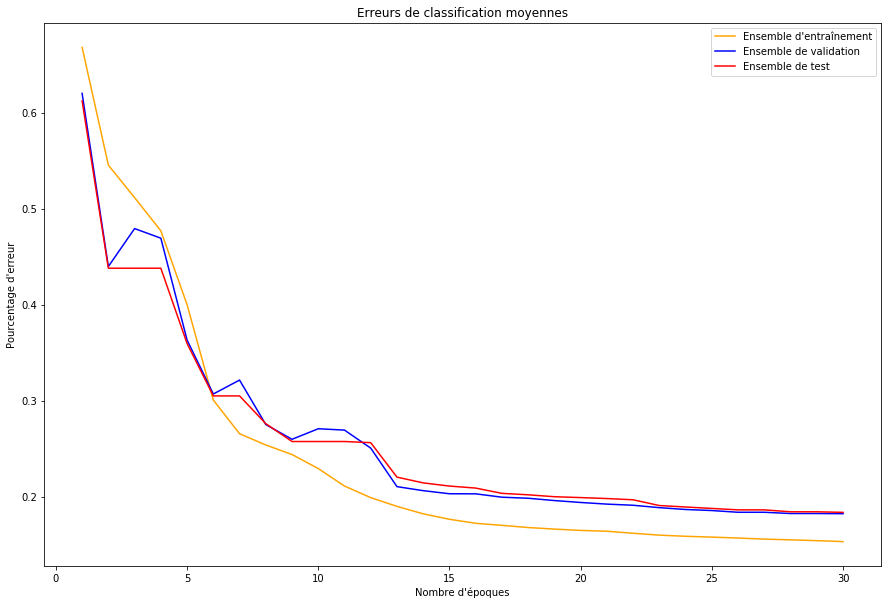

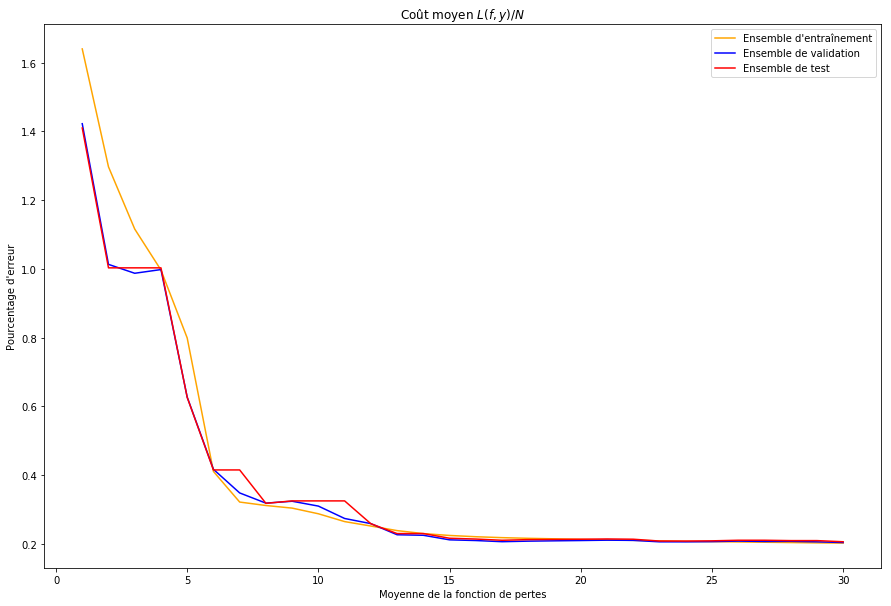

In [510]:
plt.figure(51,figsize=(15,10))
plt.plot([i+1 for i in range(30)],err_train_moy,'orange',label="Ensemble d'entraînement")
plt.plot([i+1 for i in range(30)],err_validate_moy,'b',label="Ensemble de validation")
plt.plot([i+1 for i in range(30)],err_test_moy,'r',label="Ensemble de test")
plt.title("Erreurs de classification moyennes")
plt.xlabel("Nombre d'époques")
plt.ylabel("Pourcentage d'erreur")
plt.legend(loc=0)

plt.figure(52,figsize=(15,10))
plt.plot([i+1 for i in range(30)],loss_train_moy,'orange',label="Ensemble d'entraînement")
plt.plot([i+1 for i in range(30)],loss_validate_moy,'b',label="Ensemble de validation")
plt.plot([i+1 for i in range(30)],loss_test_moy,'r',label="Ensemble de test")
plt.title("Coût moyen $L(f,y)/N$")
plt.xlabel("Moyenne de la fonction de pertes")
plt.ylabel("Pourcentage d'erreur")
plt.legend(loc=0)

## Sending the results to a text file

In [518]:
to_save=np.array([[i+1 for i in range(30)],err_train_moy,loss_train_moy,err_test_moy,loss_test_moy,loss_validate_moy,err_validate_moy])
to_save=to_save.transpose()

np.savetxt('record.txt',to_save)    # On enregistre les données nécessaires dans un fichier externe .txt